In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.datasets import mnist
import time

2023-11-22 18:16:06.296278: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-22 18:16:06.324332: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-22 18:16:06.325147: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-22 18:16:06.889902: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
def initialize():
    lamb = 0.1
    units_1, units_2, units_3 = 128, 64, 32
    scale1 = np.sqrt(2. / (units_1 + 784)) # 784 is 28x28 (i.e number of input features). Part of HE initialization
    scale2 = np.sqrt(2. / (units_1 + units_2))
    scale3 = np.sqrt(2. / (units_3 + units_2))
    scale4 = np.sqrt(2. / (10 + units_3))
    """
    W1 initializes the weight matrix for the connections between the input layer and the first hidden layer, 
    The matrix has a shape of (128, 784), 
    where 128 is the number of neurons in the first hidden layer, and 784 is the number of input features.
    The scale=scale1 argument specifies the standard deviation of the normal distribution used for initialization.

    b1 initializes the bias vector for the first hidden layer. 
    The vector has a shape of (64, 1), where units_1 is the number of neurons in the first hidden layer. 
    The np.sqrt(1./64) term is used to scale the values. This scaling factor is commonly used to initialize 
    biases to small values to prevent neurons from being saturated at the beginning of training.
    
    b should be applied to the scaling factor, not to the entire matrix.
    """
    W1 = np.random.normal(size=(units_1, 784), scale=scale1)
    b1 = np.random.normal(size=(units_1, 1)) * np.sqrt(1./units_1)
    W2 = np.random.normal(size=(units_2, units_1), scale=scale2)
    b2 = np.random.normal(size=(units_2, 1)) * np.sqrt(1./units_2)
    W3 = np.random.normal(size=(units_3, units_2), scale=scale3)
    b3 = np.random.normal(size=(units_3, 1)) * np.sqrt(1./units_3)
    W4 = np.random.normal(size=(10, units_3), scale=scale4)
    b4 = np.random.normal(size=(10, 1)) * np.sqrt(1./10)
    
    return W1, b1, W2, b2, W3, b3, W4, b4, lamb

In [4]:
def ReLU(Z):
    return np.maximum(Z,0)

def deriv_of_ReLU(Z):
    return Z > 0

def derivative_leaky_ReLU(Z, alpha=0.15):
    return np.where(Z > 0, 1, alpha)

def leaky_ReLU(Z, alpha=0.15):
    return np.where(Z > 0, Z, alpha * Z)

def softMax(Z):
    """
    The change ensures numerical stability by subtracting the maximum value from Z before exponentiating
    """
    e = np.exp(Z - np.max(Z))
    return e / e.sum(axis=0)

def one_hot(Y):
    """
    Y.max - the maximum value in the array. Used to determine the number of classes (0-9)
    Y.size - the size itself
    one_hot_y creates a one-hot encoded matrix
    where each column represents a sample, and the row corresponding 
    to the class label of that sample is set to 1. 
    """
    if Y.max() + 1 == 10:
        one_hot_y = np.zeros((Y.max()+1, Y.size))
    else:
        one_hot_y = np.zeros((Y.max()+2, Y.size))
    one_hot_y[Y, np.arange(Y.size)] = 1
    return one_hot_y

In [5]:
def forward_prop(X, W1, b1, W2, b2, W3, b3, W4, b4):
    Z1 = W1.dot(X) + b1
    A1 = leaky_ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = leaky_ReLU(Z2)
    Z3 = W3.dot(A2) + b3
    A3 = leaky_ReLU(Z3)
    Z4 = W4.dot(A3) + b4
    A4 = softMax(Z4)

    return Z1, A1, Z2, A2, Z3, A3, Z4, A4

In [6]:
def backward_prop(X, y, A1, A2, A3, A4, W1, W2, W3, W4, Z1, Z2, Z3, Z4, lamb, m):
    encoded_y = one_hot(y)
    dZ4 = A4 - encoded_y
    dW4 = 1/m * (dZ4.dot(A3.T)) + (lamb/m) * W4
    db4 = 1/m * dZ4.sum(axis=1)
    
    dZ3 = W4.T.dot(dZ4) * derivative_leaky_ReLU(Z3)
    dW3 = 1/m * (dZ3.dot(A2.T)) + (lamb/m) * W3
    db3 = 1/m * dZ3.sum(axis=1)
    
    dZ2 = W3.T.dot(dZ3) * derivative_leaky_ReLU(Z2)
    dW2 = 1/m * (dZ2.dot(A1.T)) + (lamb/m) * W2
    db2 = 1/m * dZ2.sum(axis=1)
    
    dZ1 = W2.T.dot(dZ2) * derivative_leaky_ReLU(Z1)
    dW1 = 1/m * (dZ1.dot(X.T)) + (lamb/m) * W1
    db1 = 1/m * dZ1.sum(axis=1)
    
    return dW1, db1, dW2, db2, dW3, db3, dW4, db4

def update_params(alpha, W1, b1, W2, b2, W3, b3, W4, b4, dW1, db1, dW2, db2, dW3, db3, dW4, db4):
    W1 -= alpha * dW1
    b1 -= alpha * np.reshape(db1,(W1.shape[0], 1))
    W2 -= alpha * dW2
    b2 -= alpha * np.reshape(db2,(W2.shape[0], 1))
    W3 -= alpha * dW3
    b3 -= alpha * np.reshape(db3,(W3.shape[0], 1))
    W4 -= alpha * dW4
    b4 -= alpha * np.reshape(db4, (W4.shape[0], 1))
    
    return W1, b1, W2, b2, W3, b3, W4, b4

$$J(Y, A) = -\frac{1}{m} \sum_{i=1}^{m} \sum_{j=0}^{9} Y_{ij} \log(A_{ij})$$

Y is the matrix of one-hot encoded true labels, with each row corresponding to a different example and each column corresponding to a different class (digit).
A  is the matrix of predicted probabilities, where each row represents the predicted probabilities for each class (digit) for a specific example.
m is the number of examples.
There are 10 classes (digits 0 through 9), so the inner sum goes from $j=0$ to $j=9$

$Y_{i,j}$ is the element in the i-th row and 
    j-th column of the one-hot encoded true labels matrix, indicating whether the true label for the 
    i-th example is the 
    j-th class (1 if true, 0 otherwise).
    
$A_{i,j}$ is the element in the i-th row and 
        j-th column of the predicted probabilities matrix, representing the predicted probability of the i-th example belonging to the j-th class.
        
The goal during training is to minimize this cross-entropy loss by adjusting the model's parameters through techniques like gradient descent.
$$\frac{\partial J}{\partial Z^{[3]}} = A^{[3]} - Y$$
$$\frac{\partial J}{\partial b^{[3]}} = \frac{1}{m} \sum_{i=1}^{m} (A^{[3](i)} - Y^{(i)})$$

$$\frac{\partial J}{\partial W^{[3]}} = \frac{1}{m} A^{[2]T} (A^{[3]} - Y) + \frac{\lambda}{m} W^{[3]}$$

In [7]:
def get_predictions(A4):
    return np.argmax(A4, 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y)/Y.size

In [73]:
def stochastic_gradient_descent(X, y, alpha, lamb, epochs, batch_size):
    W1, b1, W2, b2, W3, b3, W4, b4, _  = initialize()
    size, m = X.shape
    st = time.time()
    for epoch in range(epochs):
        shuffled_indices = np.random.permutation(m)
        X_shuffled = X[:, shuffled_indices]
        y_shuffled = y[shuffled_indices]
        for i in range(0, m, batch_size):
            x_mini_batch = X_shuffled[:,i:i+batch_size]
            y_mini_batch = y_shuffled[i: i+batch_size]

            Z1, A1, Z2, A2, Z3, A3, Z4, A4 = forward_prop(x_mini_batch, W1, b1, W2, b2, W3, b3, W4, b4)
            dW1, db1, dW2, db2, dW3, db3, dW4, db4 = \
            backward_prop( \
                x_mini_batch, y_mini_batch, A1, A2, A3, A4, W1, W2, W3, W4, Z1, Z2, Z3, Z4, lamb, batch_size \
            )
            W1, b1, W2, b2, W3, b3, W4, b4 = update_params(
                alpha, W1, b1, W2, b2, W3, b3, W4, b4, dW1, db1, dW2, db2, dW3, db3, dW4, db4
            )
          
            if (i+batch_size) % int(m/10) == 0:
                print(f"Backprop. Iteration - {i+batch_size} / {m}")
                prediction = get_predictions(A4)
                print(f'{get_accuracy(prediction, y_mini_batch):.3%}')
                
        full_prediction = make_predictions(X, W1, b1, W2, b2, W3, b3, W4, b4)
        epoch_accuracy = get_accuracy(full_prediction, y)
        print(f'Epoch {epoch}th finished. Time spent - {(time.time()-st):.2f}. Accuracy score - {epoch_accuracy:.3%}')
    return W1, b1, W2, b2, W3, b3, W4, b4

In [20]:
def make_predictions(X, W1 ,b1, W2, b2, W3, b3, W4, b4):
    _, _, _, _, _, _, _, A4 = forward_prop(X, W1, b1, W2, b2, W3, b3, W4, b4)
    predictions = get_predictions(A4)
    return predictions

def show_prediction(index,X, Y, W1, b1, W2, b2, W3, b3, W4, b4):
    vect_X = X[:, index,None]
    prediction = make_predictions(vect_X, W1, b1, W2, b2, W3, b3, W4, b4)
    label = Y[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    current_image = vect_X.reshape((WIDTH, HEIGHT)) * SCALE_FACTOR

    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Backprop. Iteration - 24000 / 60000
96.875%
Backprop. Iteration - 48000 / 60000
93.750%
Epoch 0th finished. Time spent - 1.51. Accuracy score - 95.390%
Backprop. Iteration - 24000 / 60000
92.188%
Backprop. Iteration - 48000 / 60000
98.438%
Epoch 1th finished. Time spent - 3.24. Accuracy score - 97.320%
Backprop. Iteration - 24000 / 60000
98.438%
Backprop. Iteration - 48000 / 60000
100.000%
Epoch 2th finished. Time spent - 4.82. Accuracy score - 97.268%
Backprop. Iteration - 24000 / 60000
98.438%
Backprop. Iteration - 48000 / 60000
100.000%
Epoch 3th finished. Time spent - 6.48. Accuracy score - 98.203%
Backprop. Iteration - 24000 / 60000
95.312%
Backprop. Iteration - 48000 / 60000
100.000%
Epoch 4th finished. Time spent - 7.97. Accuracy score - 97.870%
Backprop. Iteration - 24000 / 60000
100.000%
Backprop. Iteration - 48000 / 60000
100.000%
Epoch 5th finished. Time spent - 9.60. Accuracy score - 98.573%
Backprop. Iteration - 24000 / 60000
96.875%
Backprop. Iteration - 48000 / 60000
98.

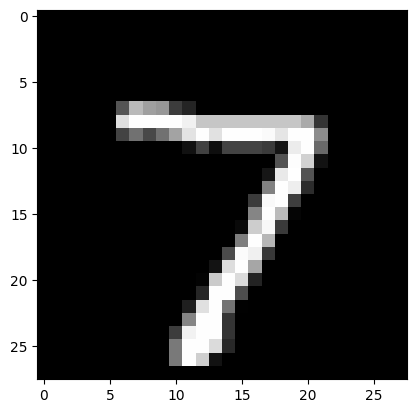

Prediction:  [2]
Label:  2


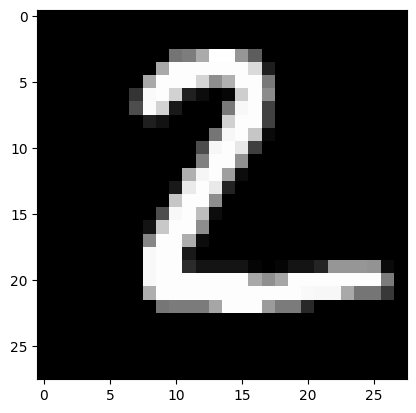

Prediction:  [1]
Label:  1


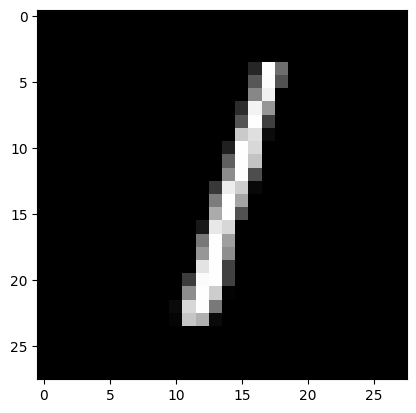

Prediction:  [6]
Label:  6


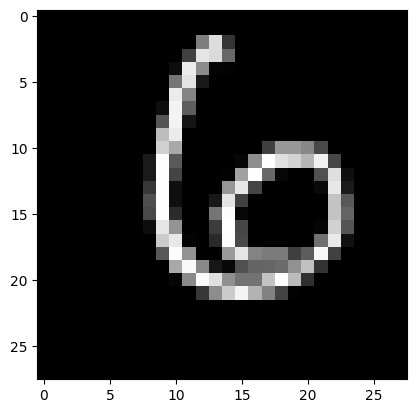

Prediction:  [3]
Label:  3


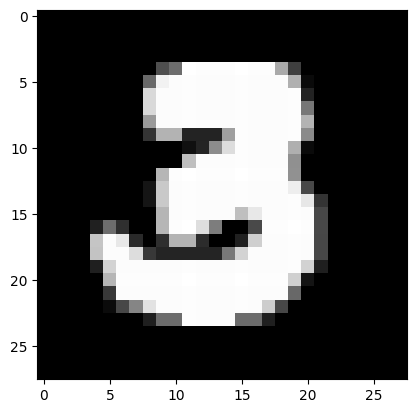

In [24]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
SCALE_FACTOR = 255
WIDTH = X_train.shape[1]
HEIGHT = X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0],WIDTH*HEIGHT).T / SCALE_FACTOR
X_test = X_test.reshape(X_test.shape[0],WIDTH*HEIGHT).T  / SCALE_FACTOR
    
W1, b1, W2, b2, W3, b3, W4, b4 = stochastic_gradient_descent(X_train, Y_train, 0.2, 0.01, 35, 64)

show_prediction(0,X_test, Y_test, W1, b1, W2, b2, W3, b3, W4, b4)
show_prediction(1,X_test, Y_test, W1, b1, W2, b2, W3, b3, W4, b4)
show_prediction(2,X_test, Y_test, W1, b1, W2, b2, W3, b3, W4, b4)
show_prediction(100,X_test, Y_test, W1, b1, W2, b2, W3, b3, W4, b4)
show_prediction(200,X_test, Y_test, W1, b1, W2, b2, W3, b3, W4, b4)

In [31]:
saved_xtrain, saved_ytrain = X_train, Y_train

In [25]:
preds = make_predictions(X_test,  W1, b1, W2, b2, W3, b3, W4, b4)
get_accuracy(preds, Y_test)

# 97.42% the best result
# 96.36% with adam
# 98.38% best result with 35 epochs (more epochs do not really improve anymore)

0.9789

In [30]:

df = pd.read_csv('digitRecognizer/digit-recognizer/train.csv')

df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
from sklearn.model_selection import train_test_split

X, y = df.iloc[:, 1:].to_numpy(), pd.get_dummies(df.iloc[:, 0]).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)


In [64]:
W1, b1, W2, b2, W3, b3, W4, b4 = stochastic_gradient_descent(X_train, Y_train, 0.2, 0.01, 35, 64)

(37800, 784)


TypeError: cannot unpack non-iterable int object

In [56]:
SCALE_FACTOR = 255
WIDTH = X_train.shape[0]
HEIGHT = X_train.shape[1]

In [57]:
saved_xtrain.shape

(784, 60000)

In [58]:
X_test.shape

(4200, 784)

In [59]:
X_test_reshaped = np.reshape(X_test, (784, 4200))

In [60]:
x_train_reshaped = np.reshape(X_train, (784, 37800))

In [61]:
x_train_reshaped.shape

(784, 37800)

In [17]:
from sklearn.metrics import f1_score, precision_score, recall_score
print(f1_score(preds, Y_test, average='macro'))
print(precision_score(preds, Y_test, average='macro'))
print(recall_score(preds, Y_test, average='macro'))
# 98.36738822135527 for f1 score
# 98.37598791297716 for precision score
# 98.36971914890565 for recall score

0.9792090403467206
0.9793279008836372
0.9792858689745332


Prediction:  [3]
Label:  1


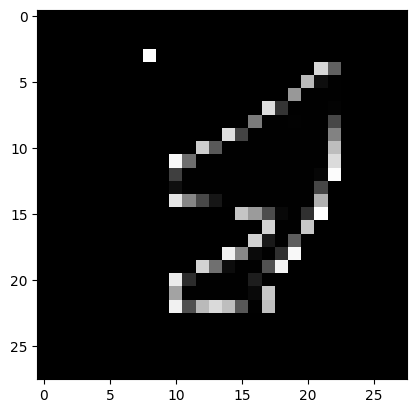

In [21]:
img20 = cv2.imread("digit.png", cv2.IMREAD_GRAYSCALE)
show_prediction(1, img20.reshape((784, 1)), 5, W1, b1, W2, b2, W3, b3, W4, b4, selfwritten=True)

In [12]:
preds_train = make_predictions(X_train, W1, b1, W2, b2, W3, b3, W4, b4)
get_accuracy(preds_train, Y_train)

0.9985666666666667

In [15]:
import cv2
import numpy as np

img3 = cv2.imread("digit5res28x28.png", cv2.IMREAD_GRAYSCALE)
img3.shape

(28, 28)

Prediction:  [3]
Label:  5


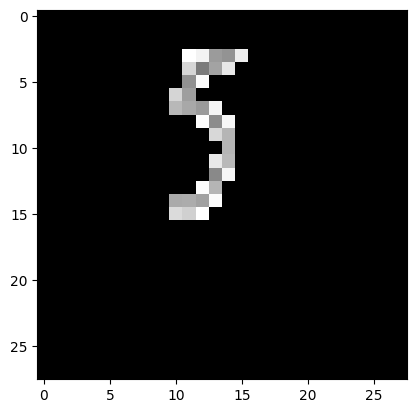

In [20]:
show_prediction(5, img3.reshape((784, 1)), 5, W1, b1, W2, b2, W3, b3, W4, b4, selfwritten=True)

Prediction:  [4]
Label:  4


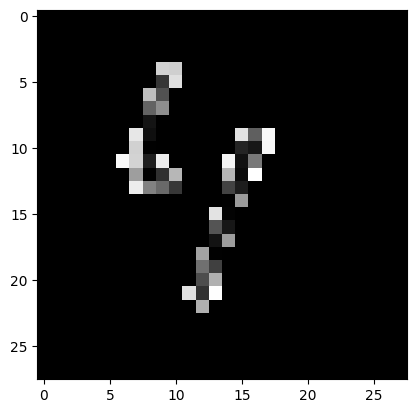

In [16]:
img4 = cv2.imread("digit4.png", cv2.IMREAD_GRAYSCALE)
show_prediction(4, img4.reshape((784, 1)), 5, W1, b1, W2, b2, W3, b3, W4, b4, selfwritten=True)

Prediction:  [2]
Label:  2


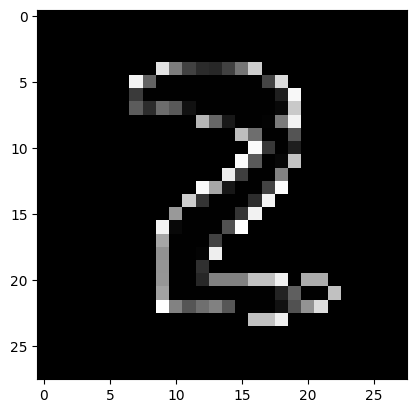

In [17]:
img5 = cv2.imread("digit2.png", cv2.IMREAD_GRAYSCALE)
show_prediction(2, img5.reshape((784, 1)), 5, W1, b1, W2, b2, W3, b3, W4, b4, selfwritten=True)

Prediction:  [8]
Label:  0


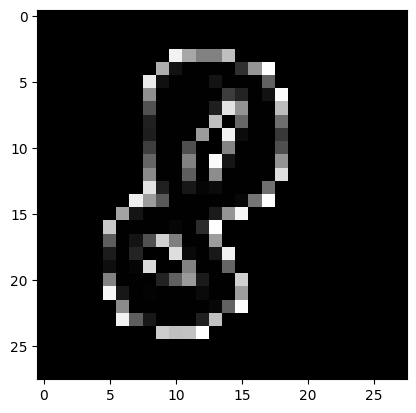

In [18]:
img6 = cv2.imread("digit8.png", cv2.IMREAD_GRAYSCALE)
show_prediction(0, img6.reshape((784, 1)), 5, W1, b1, W2, b2, W3, b3, W4, b4, selfwritten=True)